Import useful programs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ompy as om
import logging
import os
from datetime import date, datetime
import pandas as pd
from pathlib import Path

import scipy as sp
from ipywidgets import widgets

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#NormalizerSimultan imports
import copy
import json
import termtables as tt
from numpy import ndarray
from pathlib import Path
from typing import Optional, Union, Tuple, Any, Callable, Dict, Iterable, List
from scipy.stats import truncnorm
import pymultinest
from contextlib import redirect_stdout

In [2]:
om.__full_version__
print(om.__full_version__);

1.1.0.dev0+645df2f


In [3]:
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)
np.random.seed(626237)

Script to choose Gg parameter

From RIPL3:

Since there is no data for 232 (i.e. 232+1n=233), I use a median of the 234 (234+1n=235), 236 (236+1n=237) and 238 (238+1n=239)

In [4]:
Gg_234 = 26
Gg_234_error = 4
Gg_236 = 23
Gg_236_error = 2
Gg_238 = 23.6
Gg_238_error = 0.8

Gg = np.asarray([Gg_234, Gg_236, Gg_238])
Gg_232 = np.mean(Gg)

#standard error of the mean
Gg_232_error_1 = sp.stats.sem(Gg)
#uncertainty
Gg_232_error_2 = Gg_232*np.sqrt( (Gg_234_error/Gg_234)**2 +  (Gg_236_error/Gg_236)**2 + (Gg_238_error/Gg_238)**2  )

#total_error
Gg_232_error = Gg_232_error_1+Gg_232_error_2


In [5]:
#Initialize parameters that decide how fast or good the normalization should be
#adding this to for easier access to these parameters:
ensemble_members=100 #should be >100 for "real"-run
multinest_livepoints = 400 #should be >400 for "real"-run

#other variables that is noce to have easy access to:

#How many keV per bin to be used in analysis
kev_per_bin_wish = 250

# The trapeziodal cutout of the FG-matrix i.e. the data to be used in analysis
Ex_min = 2970.5
Ex_max = 5200
Eg_min = 999.9
Eg_max = 6000

#Gg normalization parameter
Gg = Gg_232
Gg_err = Gg_232_error

#norm areas (these are approx the same as OMS)
gsfnorm_high = [3.3, 4.4]
gsfnorm_low = [1.1, 1.9]

nldnorm_low = [0.1, 0.6]
nldnorm_high = [1.2,3.4]
    
now = str(datetime.now().strftime("%H:%M:%S"))
today = str(date.today())
path = 'normalized_data/U233_'+today+'_'+now+'/'

plot_path = path+'plots/'
matrix_path = path+'alfna_matrix/'
data_path = path+'data/'
norm_path = data_path+'normalizer'
multinest_path = path+'MN'

if not os.path.exists(path):
    os.makedirs(path)
    
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
    
if not os.path.exists(matrix_path):
    os.makedirs(matrix_path)
    
if not os.path.exists(data_path):
    os.makedirs(data_path)

if not os.path.exists(norm_path):
        os.makedirs(norm_path)
        
if not os.path.exists(multinest_path):
        os.makedirs(multinest_path)
        
multinest_path = Path(multinest_path)


infile = open(path+'README.txt', 'w+')
infile.write('This file contains variables used in the OMPy normalization \n')
infile.write('Name of directory indicates when the OMPy run was done \n \n')

infile.write('keV per bin: '+str(kev_per_bin_wish)+'\n \n')

infile.write('Trapezoid parameters: \n')
infile.write('Ex_min: '+str(Ex_min)+'\n')
infile.write('Ex_max: '+str(Ex_max)+'\n')
infile.write('Eg_min: '+str(Eg_min)+'\n')
infile.write('Eg_max: '+str(Eg_max)+'\n \n')

infile.write('Normalization Parameters: \n')
infile.write('Gg: '+str(Gg)+' +/- '+str(Gg_err)+'\n')
infile.write('NLD fit area low: '+str(nldnorm_low[0])+' - '+str(nldnorm_low[1])+'\n')
infile.write('NLD fit area high: '+str(nldnorm_high[0])+' - '+str(nldnorm_high[1])+'\n')
infile.write('gSF fit area low: '+str(gsfnorm_low[0])+' - '+str(gsfnorm_low[1])+'\n')
infile.write('gSF fit area high: '+str(gsfnorm_high[0])+' - '+str(gsfnorm_high[1])+'\n')
infile.close()


In [6]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

def plot_3D(matrix, filename, xlabel='xlabel', ylabel='ylabel'):
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    matrix.plot(ax=ax);
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #fig.axes[1].tick_params(labelsize=tick_labelsize)
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(filename, dpi=save_dpi)
    
def plot_2D(matrix, filename, projection_axis, xlabel='xlabel', ylabel='ylabel', yscale='log'):
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    matrix.plot_projection(projection_axis, kind="step", ax=ax);
    plt.yscale(yscale)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(filename, dpi=save_dpi)

In [7]:
def plot_matrix(matrix, fig_name, title, scale='log', x_label='$\gamma$-ray energy $E_\gamma$', ylabel='Excitation energy $E_x$'):
    fig, ax = plt.subplots(figsize=(10, 8))
    matrix.plot(ax=ax, scale=scale);
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xlabel('$\gamma$-ray energy $E_\gamma$',fontsize=18)
    ax.set_ylabel('Excitation energy $E_x$',fontsize=18)
    ax.set_title(None)
    fig.suptitle(title, fontsize=20)
    fig.axes[1].tick_params(labelsize=18)
    fig.savefig(fig_name)

In [8]:
# Import raw matrix into instance of om.Matrix()
raw = om.Matrix(path="calibrated_alfna_matrices/alfna_right_bg_timecuts")
raw_fiss = om.Matrix(path="calibrated_alfna_matrices/alfna_fiss_right_bg_timecuts")

#Rebin matrices
raw.rebin(0,factor=12)
raw.rebin(1,factor=12)
raw_fiss.rebin(0,factor=12)
raw_fiss.rebin(1,factor=12)


In [9]:
raw.save(matrix_path+'alfna_right_bg_timecuts.m')

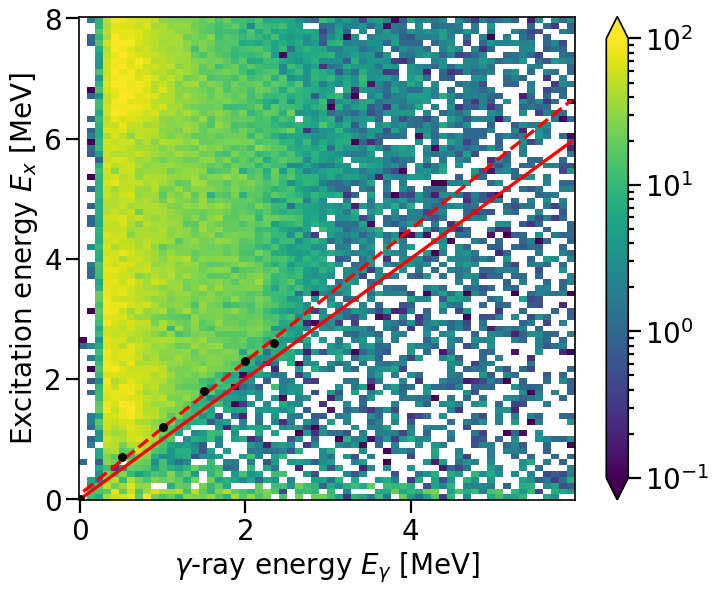

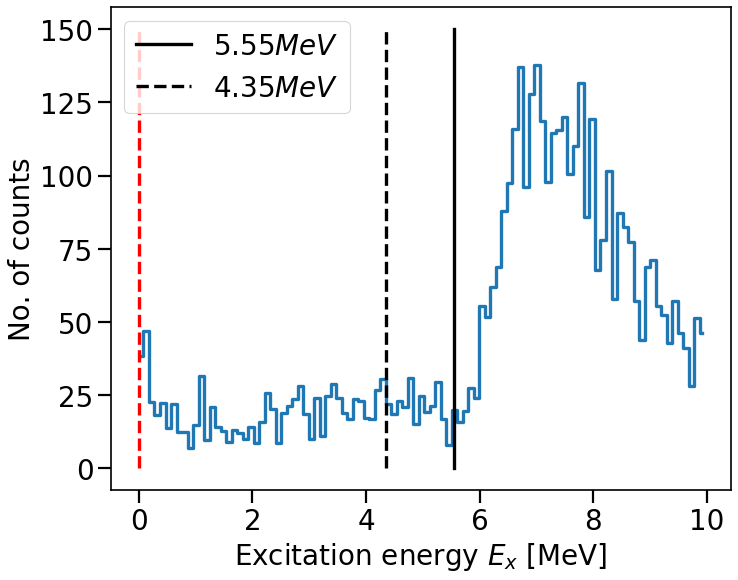

In [10]:
#plot raw matrix
raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 8000)
raw_plot_big.cut('Eg', 0, 6000)
raw_plot_big.Ex = raw_plot_big.Ex*1e-3
raw_plot_big.Eg = raw_plot_big.Eg*1e-3

raw_plot_big_fiss = raw_fiss.copy()
raw_plot_big_fiss.cut('Ex', 0, 10000)
raw_plot_big_fiss.cut('Eg', 0, 6000)
raw_plot_big_fiss.Ex = raw_plot_big_fiss.Ex*1e-3
raw_plot_big_fiss.Eg = raw_plot_big_fiss.Eg*1e-3

Ex = raw_plot_big.Ex
Eg = raw_plot_big.Eg

fig, ax = plt.subplots()
raw_plot_big.plot(ax=ax, vmin=1e-1, vmax=1e2);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.plot(Eg, Eg, "r", label="E_x = E_g");

#Plot new diagonal to be used for calibration

#Linefit to calibrate Ex

#finding calibration points alog the diagonal
p0 = [0,0]
p1 = [.5, .7]
p2 = [1, 1.2]
p3 = [1.5, 1.8]
p4 = [2, 2.3]
p5 = [2.35, 2.6]

#linefit
y_linefit = np.asarray([p0[1], p1[1], p2[1], p3[1], p4[1], p5[1]])
x_linefit = np.asarray([p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]])
z = np.polyfit(x_linefit, y_linefit, 1)
poly = np.poly1d(z)
new_diag = Eg*poly[1] + poly[0]
ax.plot(Eg, new_diag, 'r--');

#finding calibration points alog the diagonal
ax.plot(p0[0], p0[1], 'ko', markersize=7.0);
ax.plot(p1[0], p1[1], 'ko', markersize=7.0);
ax.plot(p2[0], p2[1], 'ko', markersize=7.0);
ax.plot(p3[0], p3[1], 'ko', markersize=7.0);
ax.plot(p4[0], p4[1], 'ko', markersize=7.0);
ax.plot(p5[0], p5[1], 'ko', markersize=7.0);

fig.savefig(plot_path+'raw_uncalibrated')



#plot projection
fig, ax = plt.subplots()
raw_plot_big_fiss.plot_projection('Ex', Emin=0, Emax=8, kind="step", ax=ax);
ax.set_ylabel('No. of counts')
ax.set_xlabel('Excitation energy $E_x$ [MeV]')
ax.plot([5.550, 5.550], [0, 150], color='black', label="$5.55MeV$");
ax.plot([4.350, 4.350], [0, 150], '--', color='black', label="$4.35MeV$");
ax.plot([0, 0], [0, 150], '--', color='red');
ax.legend(loc='upper left');
fig.savefig(plot_path+'Ex_py_fiss_uncalibrated')

In [11]:
#Calibrate Ex to new diagonal which is decided here
new_diag = raw.Ex*poly[1] + poly[0]

raw.Ex = 2*raw.Ex - new_diag
raw_fiss.Ex = 2*raw_fiss.Ex - new_diag

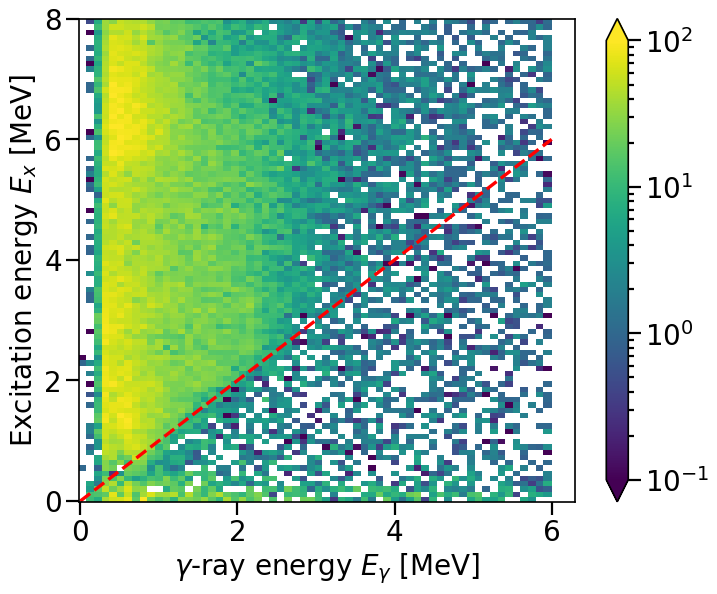

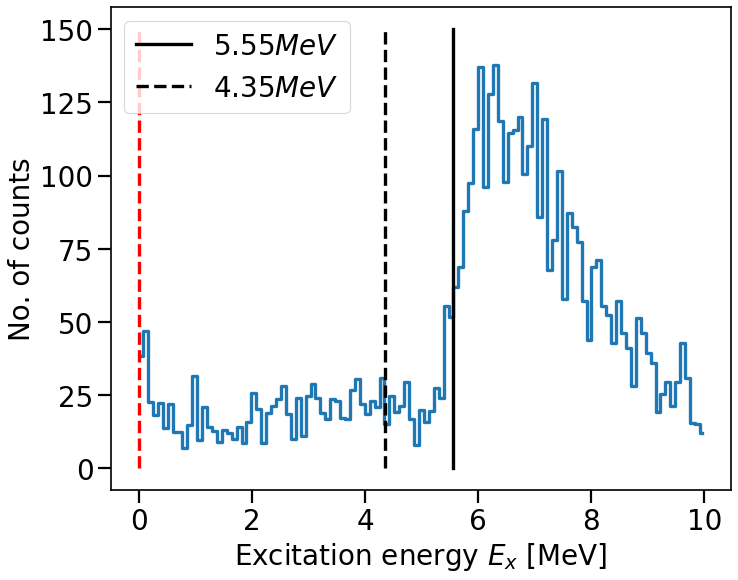

In [12]:
#plot raw matrix after calibration

raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 8000)
raw_plot_big.cut('Eg', 0, 6000)
raw_plot_big.Ex = raw_plot_big.Ex*1e-3
raw_plot_big.Eg = raw_plot_big.Eg*1e-3

raw_plot_big_fiss = raw_fiss.copy()
raw_plot_big_fiss.cut('Ex', 0, 10000)
raw_plot_big_fiss.cut('Eg', 0, 6000)
raw_plot_big_fiss.Ex = raw_plot_big_fiss.Ex*1e-3
raw_plot_big_fiss.Eg = raw_plot_big_fiss.Eg*1e-3


fig, ax = plt.subplots()
raw_plot_big.plot(ax=ax, vmin=1e-1, vmax=1e2);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
x = np.linspace(0, 6, len(raw.Ex))
ax.plot(x, x, "r--", label="E_x = E_g");
fig.savefig(plot_path+'raw_calibrated')


#plot projection
fig, ax = plt.subplots()
raw_plot_big_fiss.plot_projection('Ex', Emin=0, Emax=8, kind="step", ax=ax);
ax.set_ylabel('No. of counts')
ax.set_xlabel('Excitation energy $E_x$ [MeV]')
ax.plot([5.550, 5.550], [0, 150], color='black', label="$5.55MeV$");
ax.plot([4.350, 4.350], [0, 150], '--', color='black', label="$4.35MeV$");
ax.plot([0, 0], [0, 150], '--', color='red');
ax.legend(loc='upper left');
fig.savefig(plot_path+'Ex_py_fiss_calibrated')

In [13]:
#Rebin raw matrix (I do not use this anymore, can delete)
def rebin_cut(mat, kev_per_bin_wish, cut_lim, save_plot, keep=False, rebin=True, cut=True, plot=True):
    """
    Cuts raw matrix Eg and Ex at approximately cut and rebins Eg and Ex with new kev_per_bin_wish
    Cuts away diagonal too
    """
    
    mat_rebin = mat.copy()
    cut_lim = kev_per_bin_wish*round(cut_lim/kev_per_bin_wish)
    if cut==True:
        mat_rebin.cut('Ex', 0, cut_lim)
        mat_rebin.cut('Eg', 0, cut_lim)
 
    new_mids = np.linspace(kev_per_bin_wish/2, cut_lim-(kev_per_bin_wish/2), int(cut_lim/kev_per_bin_wish))
    if rebin==True:
        mat_rebin.rebin('Ex', mids=new_mids) #rebinning the Eg energy axis
        mat_rebin.rebin('Eg', mids=new_mids) #rebinning the Ex energy axis
    
    mat_rebin.cut_diagonal(E1=(kev_per_bin_wish, 0), E2 = (cut_lim*2 + kev_per_bin_wish, cut_lim*2))
    
    dEx = mat_rebin.Ex[1] - mat_rebin.Ex[0]
    print('New KeV per bin: %.3f'%dEx)
    
    mat_rebin_plot = mat_rebin.copy()
    mat_rebin_plot.Ex = mat_rebin_plot.Ex*1e-3
    mat_rebin_plot.Eg = mat_rebin_plot.Eg*1e-3
    Ex = mat_rebin_plot.Ex
    Eg = mat_rebin_plot.Eg
    
    if plot==True:
    #plot matrix
        fig, ax = plt.subplots()
        mat_rebin_plot.plot(ax=ax, vmin=1e-1, vmax=1e3);
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
        ax.set_ylabel('Excitation energy $E_x$ [MeV]')
        #ax.plot(Ex, Eg, "r--");
        ax.grid(color='k', linestyle='--', linewidth=.5)
        fig.savefig(plot_path+save_plot)
        ax.set_title(save_plot+' w. %.3f kev/bin'%dEx, fontsize=20)
    if keep==True:
        return mat_rebin
        #raw=raw_rebin
        #raw.rebin('Ex', mids=new_mids)
        #raw.rebin('Eg', mids=new_mids)
    if keep==False:
        return mat

Cutting matrix into desired size

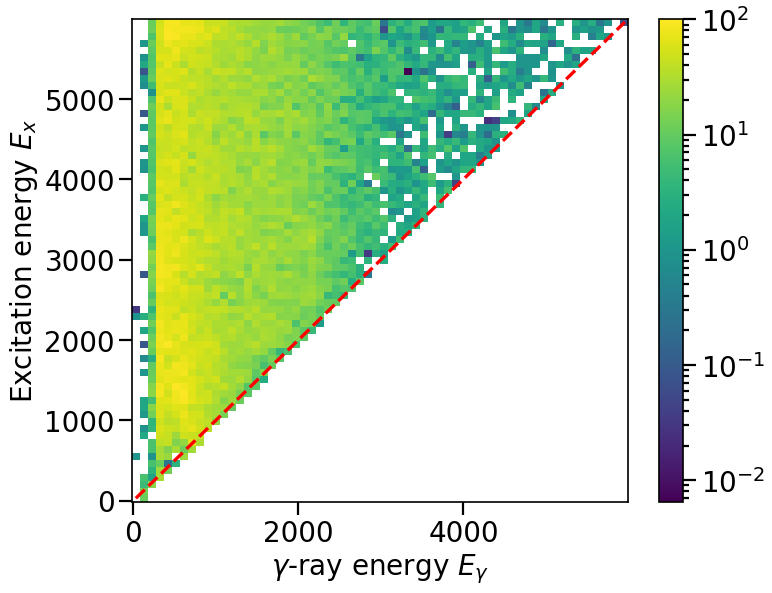

In [14]:
cut_lim = 6000
raw_cut = raw.copy()
raw_cut.cut('Ex', 0, cut_lim)
raw_cut.cut('Eg', 0, cut_lim)
dEx = raw_cut.Ex[1]-raw_cut.Ex[0]
raw_cut.cut_diagonal(E1=(dEx, 0), E2 = (cut_lim*2-dEx, cut_lim*2))
fig, ax = plt.subplots()
raw_cut.plot(ax=ax)
ax.plot(raw_cut.Ex, raw_cut.Ex, 'r--')
fig.show()

raw = raw_cut

From the GettingStarted OmPy manual: "Eventhough this experiment was performed with CACTUS, we will now give an example as if the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately."

So, I need to include the detector threshold for CACTUS

2021-02-04 22:43:13,906 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.
2021-02-04 22:43:14,355 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


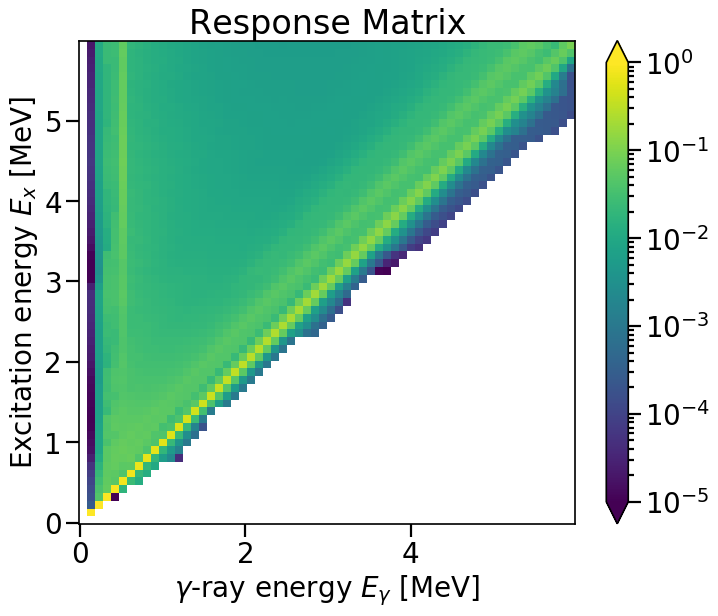

In [15]:
### GETTING RESPONSE MATRIX


logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
folderpath = "OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 90.44 # (90/1330 = 6.8%) #CACTUS

response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
# Magne recommends 1/10 of the actual resolution for unfolding purposes (see article)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

R_ompy_view.save(matrix_path+"R_ompy_view.m")
R_ompy_unf.save(matrix_path+"R_ompy_unf.m")
R_tab_view.to_pickle(matrix_path+"R_tab_view.pkl")
R_tab_unf.to_pickle(matrix_path+"R_tab_unf.pkl")

# adding response function for CACTUS
fthreshold = sp.interpolate.interp1d([30., 80., 122., 183., 244., 294., 344., 562., 779., 1000.],
                      [0.0, 0.0, 0.0, 0.06, 0.44, 0.60, 0.87, 0.99, 1.00, 1.00],
                      fill_value="extrapolate") #from mama-software ('folding.f')

def apply_detector_threshold(response, table, fthreshold):
    thres = fthreshold(response.Eg)
    response.values = response.values * thres
    # renormalize
    response.values = om.div0(response.values, response.values.sum(axis=1)[:, np.newaxis])
    table["eff_tot"] *= thres

apply_detector_threshold(R_ompy_unf, R_tab_unf, fthreshold)
apply_detector_threshold(R_ompy_view, R_tab_view, fthreshold)


R_ompy_view_plot = R_ompy_view.copy()
R_ompy_view_plot.Ex = R_ompy_view_plot.Ex*1e-3
R_ompy_view_plot.Eg = R_ompy_view_plot.Eg*1e-3

fig, ax = plt.subplots()
R_ompy_view_plot.plot(ax=ax, scale="log", vmin=1e-5, vmax=1e0);
ax.tick_params(axis='both')
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.set_title('Response Matrix')
fig.savefig(plot_path+'response_matrix_%.0i_kevperbin'%kev_per_bin_wish)

Text(0.5, 1, 'Unfolded')

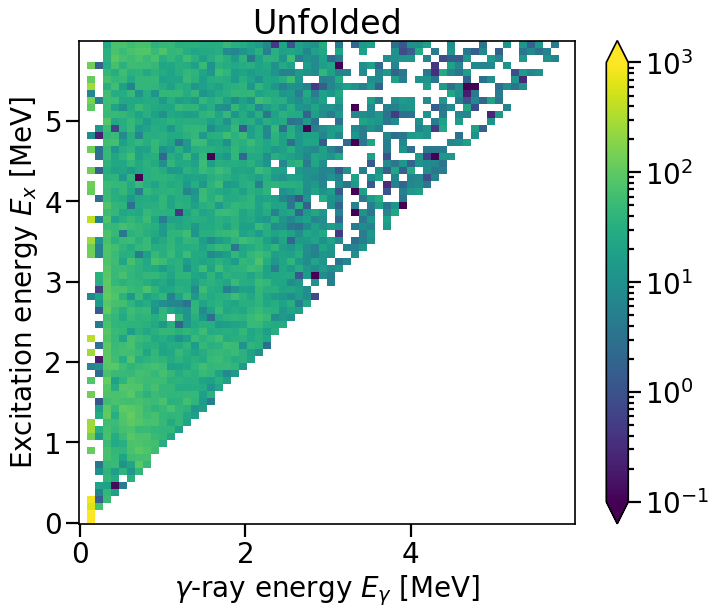

In [16]:
### UNFOLDING

# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=20)

# With compton subtraction and all tweaks
unfolder = om.Unfolder(num_iter = 500, response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9} #SJEKK DETTE
unfolded = unfolder(raw_positive)

unfolded_plot = unfolded.copy()
unfolded_plot.Ex = unfolded_plot.Ex*1e-3
unfolded_plot.Eg = unfolded_plot.Eg*1e-3

fig, ax = plt.subplots()
unfolded_plot.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.set_title('')
fig.savefig(plot_path+'unfolded_matrix_%.0i_kevperbin'%kev_per_bin_wish)
ax.set_title('Unfolded')



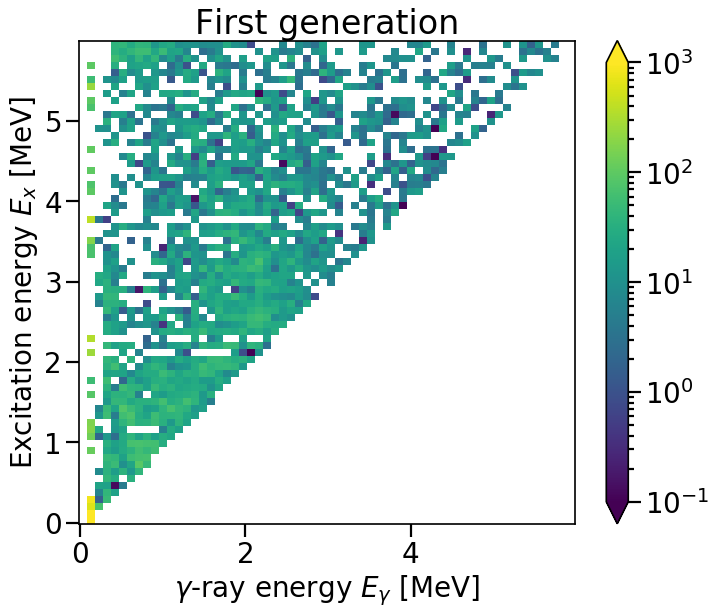

In [17]:
### Generate the first generation matrix

firstgen = om.FirstGeneration()
primary = firstgen(unfolded)

primary_plot = primary.copy()
primary_plot.Ex = primary_plot.Ex*1e-3
primary_plot.Eg = primary_plot.Eg*1e-3

fig, ax = plt.subplots()
primary_plot.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.set_title('First generation');

In [18]:
### Propagating statistical uncertainties

logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of unfolder and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
if not os.path.exists(data_path+'ensemble_path'):
    os.makedirs(data_path+'ensemble_path')
ensemble = om.Ensemble(raw=raw_positive, path=data_path+'ensemble_path')
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members
# the `regenerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(ensemble_members, regenerate=True)

2021-02-04 22:43:17,892 - ompy.ensemble - INFO - Start normalization with 3 cpus
2021-02-04 22:43:18,255 - ompy.ensemble - INFO - Generating/loading 0


2021-02-04 22:43:18,375 - ompy.ensemble - INFO - Generating/loading 1
2021-02-04 22:43:18,502 - ompy.ensemble - INFO - Generating/loading 2
2021-02-04 22:43:20,698 - ompy.ensemble - INFO - Generating/loading 3
2021-02-04 22:43:20,745 - ompy.ensemble - INFO - Generating/loading 4
2021-02-04 22:43:20,907 - ompy.ensemble - INFO - Generating/loading 5
2021-02-04 22:43:22,198 - ompy.ensemble - INFO - Generating/loading 6
2021-02-04 22:43:22,272 - ompy.ensemble - INFO - Generating/loading 7
2021-02-04 22:43:22,320 - ompy.ensemble - INFO - Generating/loading 8
2021-02-04 22:43:23,510 - ompy.ensemble - INFO - Generating/loading 9
2021-02-04 22:43:23,703 - ompy.ensemble - INFO - Generating/loading 10
2021-02-04 22:43:23,761 - ompy.ensemble - INFO - Generating/loading 11
2021-02-04 22:43:25,029 - ompy.ensemble - INFO - Generating/loading 12
2021-02-04 22:43:25,131 - ompy.ensemble - INFO - Generating/loading 13
2021-02-04 22:43:25,208 - ompy.ensemble - INFO - Generating/loading 14
2021-02-04 22:4

Extract Nuclear level density and gamma strength function

2021-02-04 22:44:14,838 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2021-02-04 22:44:14,839 - ompy.extractor - INFO - Minimizing
2021-02-04 22:44:15,096 - ompy.extractor - INFO - Optimization terminated successfully.
2021-02-04 22:44:15,097 - ompy.extractor - INFO -          Current function value: 227.167617
2021-02-04 22:44:15,098 - ompy.extractor - INFO -          Iterations: 5
2021-02-04 22:44:15,099 - ompy.extractor - INFO -          Function evaluations: 2270
2021-02-04 22:44:15,141 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2021-02-04 22:44:15,143 - ompy.extractor - INFO - Minimizing
2021-02-04 22:44:15,418 - ompy.extractor - INFO - Optimization terminated successfully.
2021-02-04 22:44:15,420 - ompy.extractor - INFO -          Current function value: 197.108174
2021-02-04 22:44:15,421 - ompy.extractor - INFO -          Iterations: 5
2021-02-04 22:44:15,423 - ompy.extractor - INFO -          Function evaluations: 227

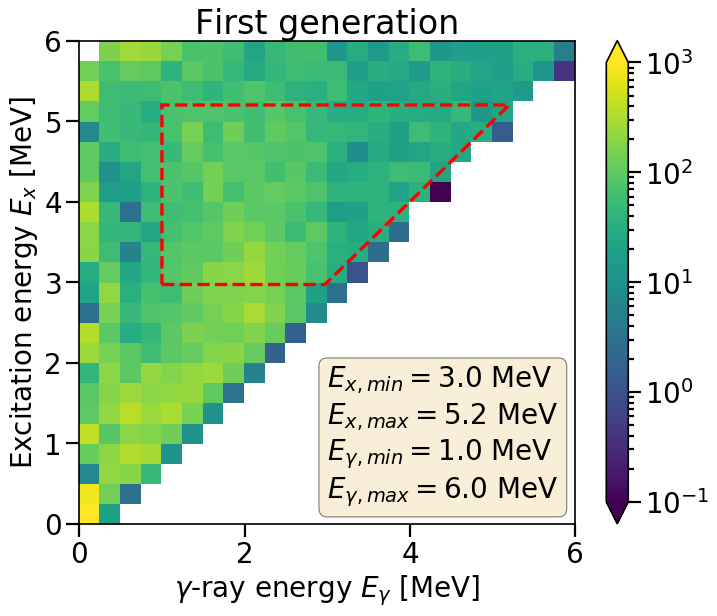

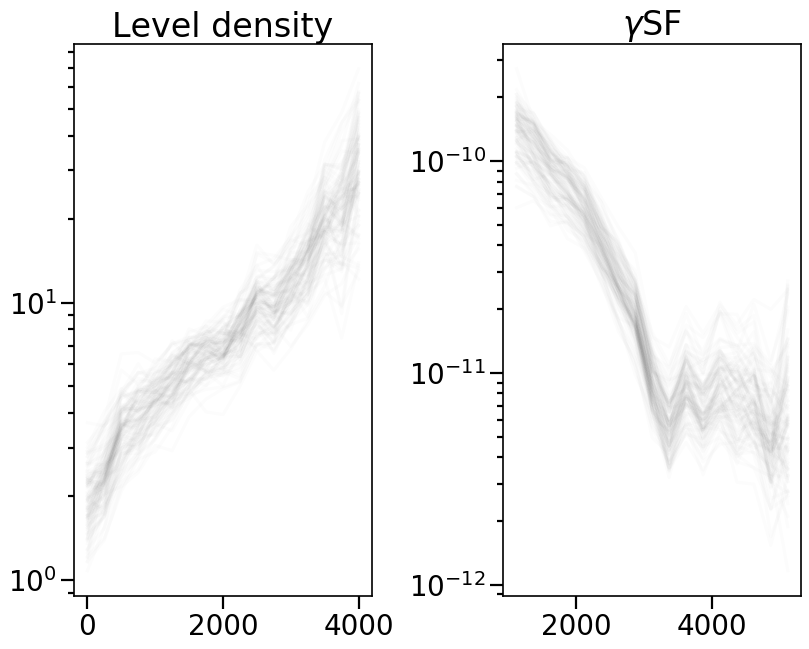

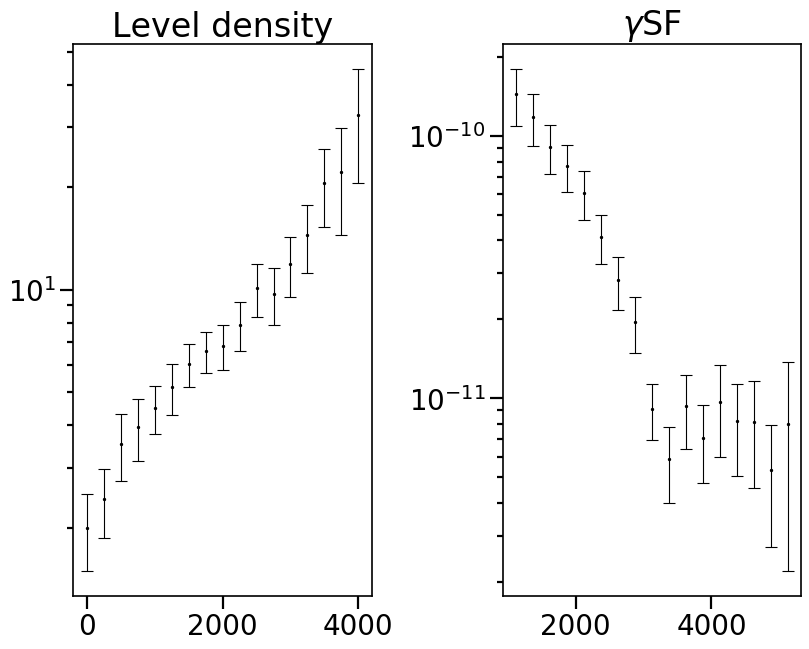

In [19]:
extlog = om.introspection.get_logger('extractor', 'INFO')

#defining new bins for rebinning
#based on the choice of keV/bin and the initial cut of the matrix
new_mids = np.linspace(kev_per_bin_wish/2, cut_lim-(kev_per_bin_wish/2), int(cut_lim/kev_per_bin_wish))
primary.rebin('Ex', mids = new_mids)
primary.rebin('Eg', mids = new_mids)


primary_plot = primary.copy()
primary_plot.Ex = primary_plot.Ex*1e-3
primary_plot.Eg = primary_plot.Eg*1e-3


#plot primary matrix with trapezoidal cuts and new binning:
fig, ax = plt.subplots()
primary_plot.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
# Trapez
x = [Eg_min*1e-3, Ex_min*1e-3, Ex_max*1e-3, Eg_min*1e-3]
y = [Ex_min*1e-3, Ex_min*1e-3, Ex_max*1e-3, Ex_max*1e-3]
textstr = '\n'.join((
    r'$E_{x, min}=%.1f$ MeV' % (Ex_min*1e-3, ),
    r'$E_{x, max}=%.1f$ MeV' % (Ex_max*1e-3, ),
    r'$E_{\gamma, min}=%.1f$ MeV' % (Eg_min*1e-3, ),
    r'$E_{\gamma, max}=%.1f$ MeV' % (Eg_max*1e-3, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(.5, 0.33, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)

ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, linewidth=3.0, color='r', linestyle='--'))
ax.set_title('')
fig.savefig(plot_path+'firstgen_matrix')
ax.set_title('First generation')


#Perform trapezoidal cut
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=Ex_min, Ex_max=Ex_max, Eg_min=Eg_min, Eg_max = Ex_max+kev_per_bin_wish, inplace=True)

if not os.path.exists(data_path+'extraction_ensemble'):
    os.makedirs(data_path+'extraction_ensemble')
    
extractor = om.Extractor(path=data_path+'extraction_ensemble')
extractor.trapezoid = trapezoid_cut

#rebin firstgen matrix from ensemble
ensemble.rebin(new_mids, member="firstgen", )

#extract NLD and gSF from ensemble
extractor.extract_from(ensemble, regenerate=True)

extractor.plot(scale='log', plot_mean=False);
plt.savefig(plot_path+'unnormed_new_falsemean')

extractor.plot(scale='log', plot_mean=True);
plt.savefig(plot_path+'unnormed_new_truemean')

2021-02-04 22:44:51,804 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2021-02-04 22:44:51,806 - ompy.extractor - INFO - Minimizing
2021-02-04 22:44:52,071 - ompy.extractor - INFO - Optimization terminated successfully.
2021-02-04 22:44:52,072 - ompy.extractor - INFO -          Current function value: 227.160113
2021-02-04 22:44:52,073 - ompy.extractor - INFO -          Iterations: 5
2021-02-04 22:44:52,074 - ompy.extractor - INFO -          Function evaluations: 2296


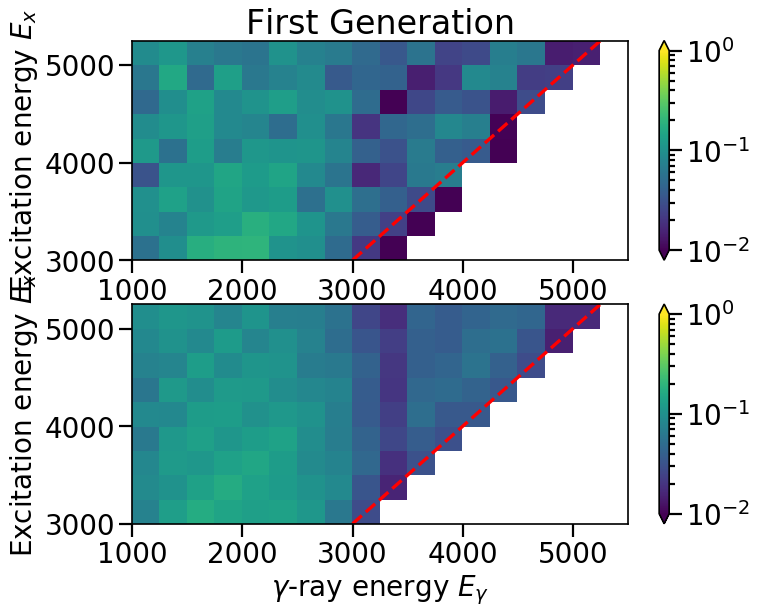

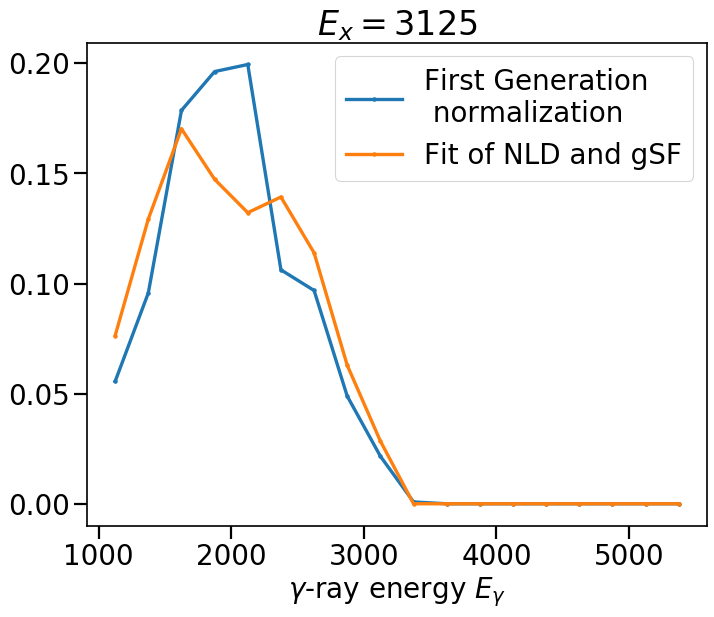

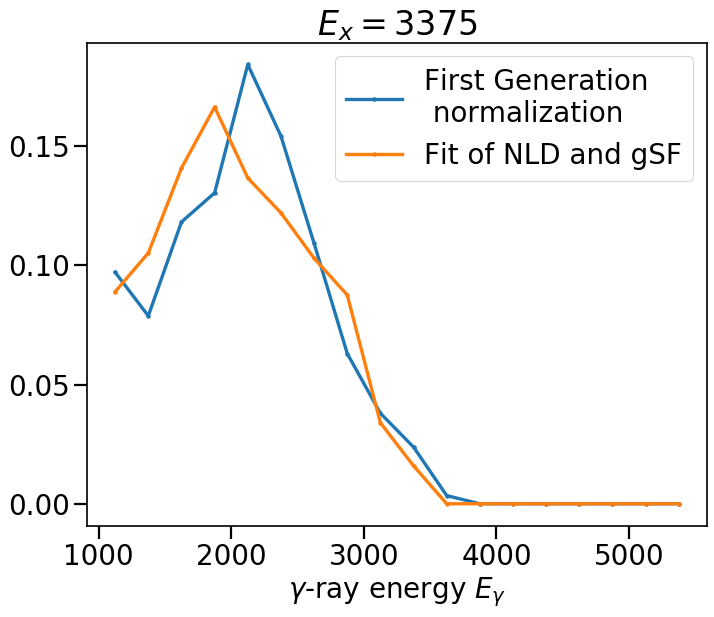

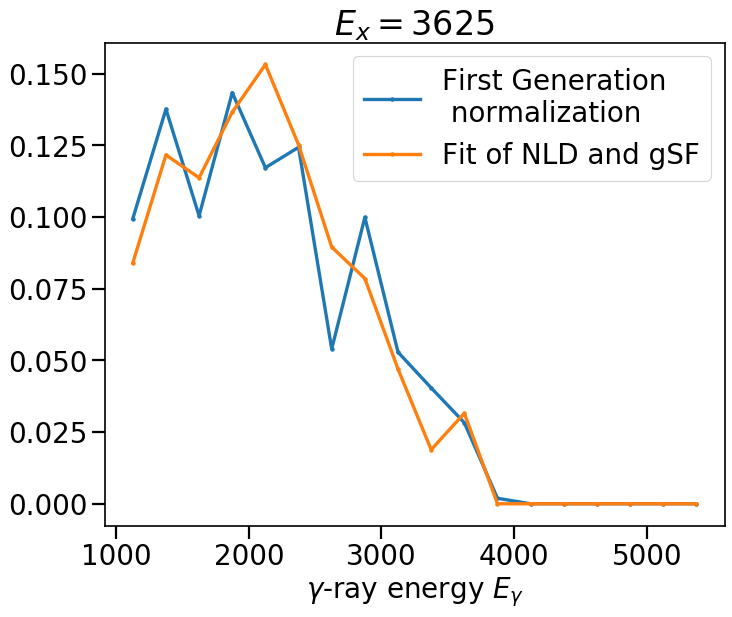

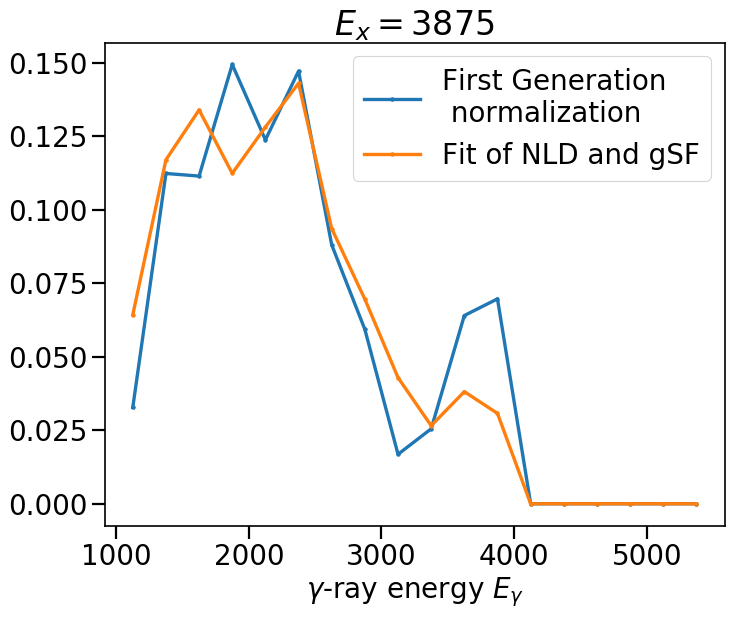

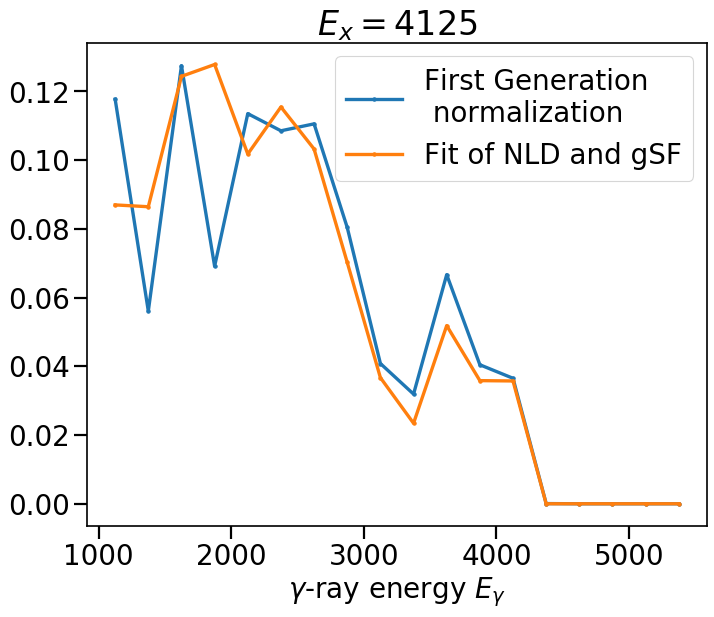

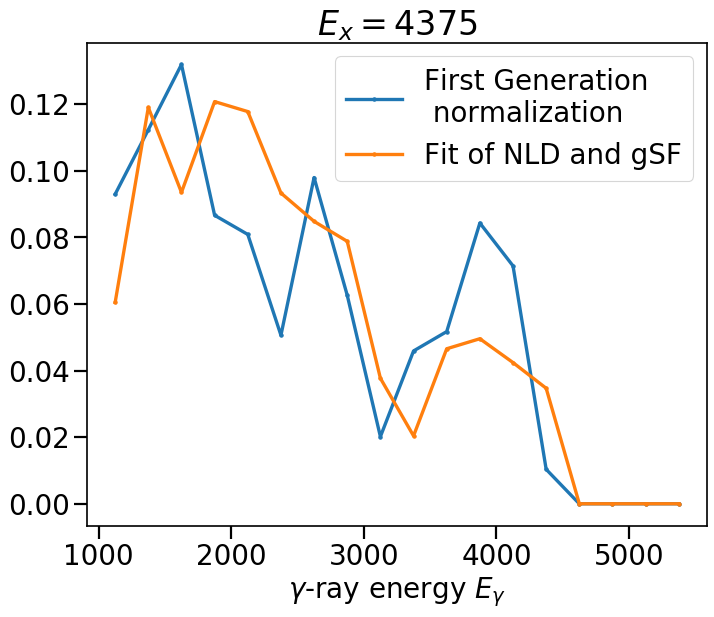

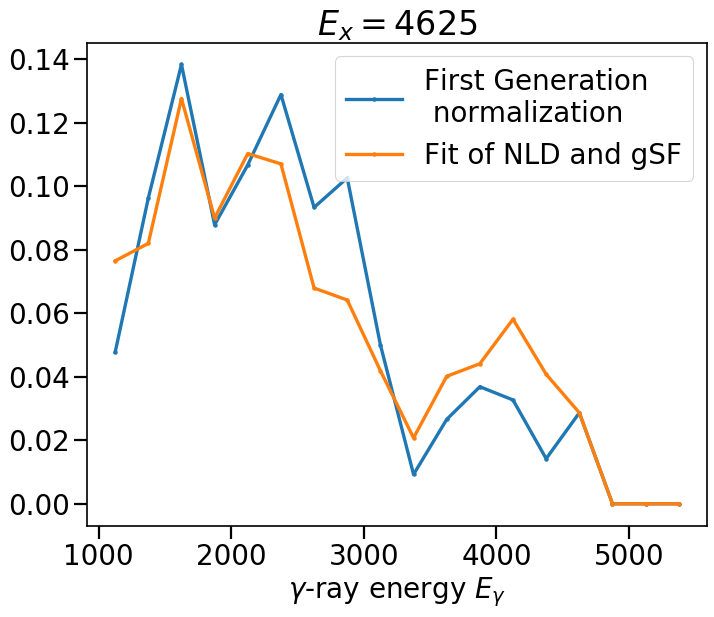

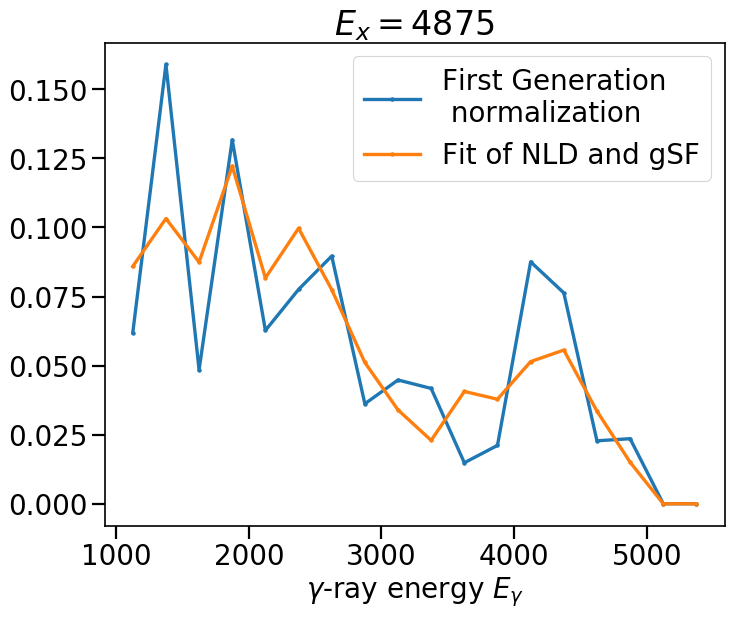

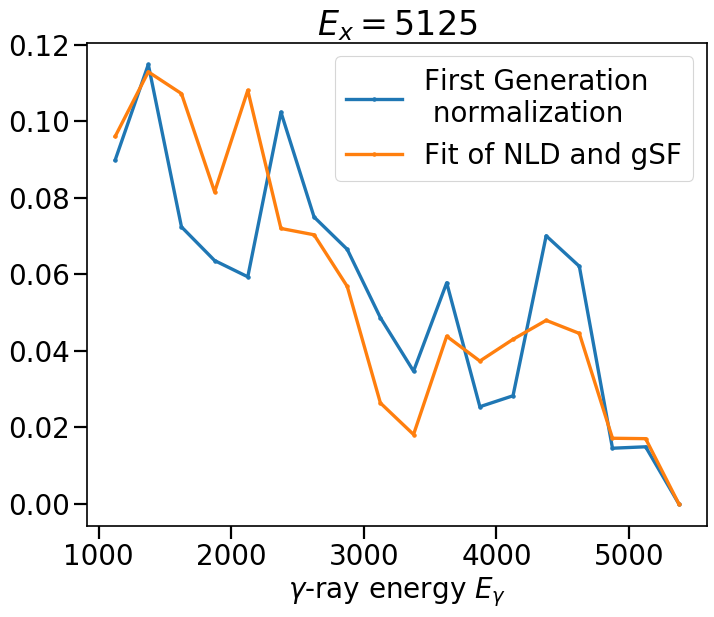

In [20]:
#plotting the first generation matrix and the fit of first gen matrix from the
#unnormalizaed but extracted gsf and nld

mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen.copy()
trapezoid_cut.act_on(mat)
trapezoid_cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)
fig, ax = plt.subplots(2,1)
om.normalize_rows(mat.values)
mat.plot(ax=ax[0], scale="log", vmin=1e-2, vmax=1e0)
product.plot(ax=ax[1], scale="log", vmin=1e-2, vmax=1e0)

x = np.linspace(*ax[0].get_ylim())
ax[0].plot(x, x, "r--", label="E_x = E_g")
ax[1].plot(x, x, "r--", label="E_x = E_g");

#plotting the Eg projection for each Ex, for the same conditions as above

for Ex in mat.Ex:
    fig, ax = plt.subplots()
    mat.plot_projection('Eg', ax=ax, Emin=Ex, Emax=Ex, label='First Generation \n normalization')
    product.plot_projection('Eg', ax=ax, Emin=Ex, Emax=Ex, label='Fit of NLD and gSF')
    ax.legend()
    ax.set_title('$E_x = $%.0i'%Ex)
    fig.show()

In [21]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
for nld in extractor.nld:
    nld.cut_nan()

for gsf in extractor.gsf:
    gsf.cut_nan()

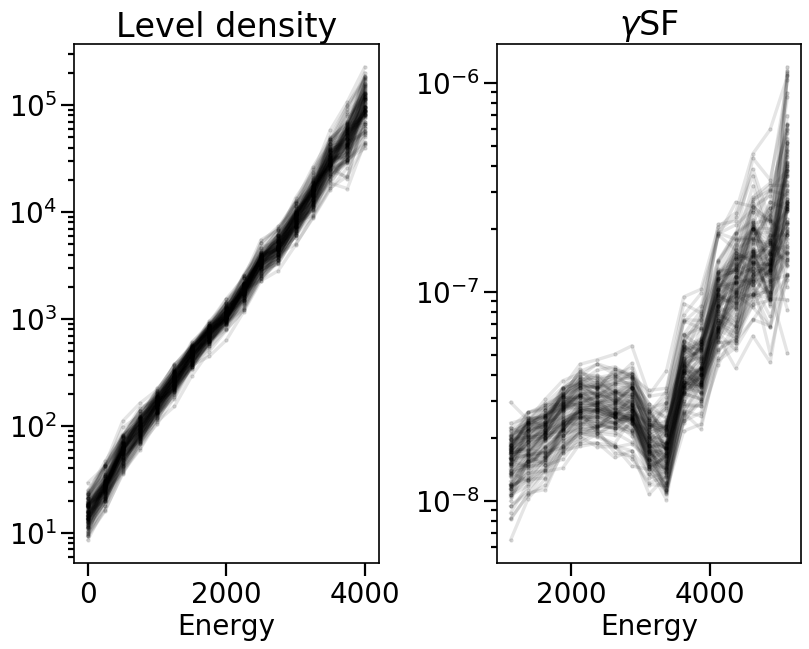

In [22]:
def plot_transformed(alpha, A=8, B=20):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].set_title("Level density")
    ax[1].set_title(r"$\gamma$SF")

plot_transformed(alpha=0.0015)

Normalization parameters and explanation:

D0: 4.6 +/- 0.7 Average s-wave resonance spacing D0 [eV] Taken from https://www-nds.iaea.org/RIPL-3/, https://www-nds.iaea.org/cgi-bin/ripl_den_ldp.pl?Z=92&A=233

Sn: Neutron separation energy [MeV] Taken from https://www-nds.iaea.org/RIPL-3/, https://www-nds.iaea.org/cgi-bin/ripl_levels.pl?Z=92&A=233

Spincut pars. Parameters necessary for the spin cut model:
    NLDa: Level density parameter. Taken from https://journals.aps.org/prc/abstract/10.1103/PhysRevC.80.054310 (Egidy, Bucurescu 2009)
    
    Eshift: Total backshift parameter. Taken from https://journals.aps.org/prc/abstract/10.1103/PhysRevC.80.054310 (Egidy, Bucurescu 2009)
    
    sigma2_disc: [Energy, sigma2] from the discrete levels
    
Jtarget: 5/2+ “Target” (A-1 nucleus) ground state spin. From https://www-nds.iaea.org/cgi-bin/ripl_levels.pl?Z=92&A=233

nldnorm:
    limit_low:
    
    limit_high:
    
gsfnorm:
    Gg: Total average radiative width [meV]
    
    
printout from ompy source-code 
        """ Get the square of the spin cut for a specified model 

        if model == "const":
            pars_req = {"sigma"}
            return call_model(self.gconst, pars, pars_req)
        elif model == "EB05":
            pars_req = {"mass", "NLDa", "Eshift"}
            return call_model(self.gEB05, pars, pars_req)
        elif model == "EB09_CT":
            pars_req = {"mass"}
            return call_model(self.gEB09_CT, pars, pars_req)
        elif model == "EB09_emp":
            pars_req = {"mass", "Pa_prime"}
            return call_model(self.gEB09_emp, pars, pars_req)
        elif model == "Disc_and_EB05":
            pars_req = {"mass", "NLDa", "Eshift", "Sn", "sigma2_disc"}
            return call_model(self.gDisc_and_EB05, pars, pars_req)
            
The different spin-cutoff models to use. Which one?

In [23]:
##Normalization parameters
regenerator = True
def init_normalizers():
    
    norm_pars = om.NormalizationParameters(name='233U')
    norm_pars.D0 = [4.6, 0.7]  # eV #SJEKK
    norm_pars.Sn = [5.762, 0] # MeV #SJEKK

    #Which spin-cutoff model to use (uncomment to use):

    #norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
    #norm_pars.spincutPars = {"mass":233, "NLDa":25.395, "Eshift":-0.519, "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}

    #norm_pars.spincutModel = 'EB09_CT'
    #norm_pars.spincutPars = {"mass":233}

    norm_pars.spincutModel = 'EB05'
    norm_pars.spincutPars = {"mass":233, "NLDa":25.395, "Eshift":-0.519}


    norm_pars.Jtarget = 0 # A-1 nucleus (232U)

    # NLD normalizer parameters

    normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
    
    nldnorm = om.NormalizerNLD(nld=extractor.nld[66], 
                               discrete='discrete_levels_U233.txt', 
                               regenerate=regenerator,
                               path=norm_path)

    nldnorm.smooth_levels_fwhm = 0.1 #0.1 MeV = 100keV is default
    nldnorm.limit_low = nldnorm_low
    nldnorm.limit_high = nldnorm_high
    
    #nldnorm.bounds["A"] = [0.001, 100]
    #nldnorm.bounds["alpha"] = [1, 2]
    nldnorm.bounds['T'] = [0.2, 0.5]

    # gSF normalizer parameters

    normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
    gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, 
                               gsf=extractor.gsf[66], 
                               regenerate=regenerator, 
                               path=norm_path)

    # to be used for gsf normalization
    norm_pars.Gg = [Gg, Gg_err] 

    #dont delete
    #gsfnorm.model_high.Efit = [3.7, 4.6]
    #gsfnorm.model_low.Efit = [1.8, 2.4]

    gsfnorm.model_high.Efit = gsfnorm_high
    gsfnorm.model_low.Efit = gsfnorm_low
    
    
    gsfnorm.norm_pars = norm_pars
    nldnorm.norm_pars = norm_pars
    
    #rhoSn and error as calculated in OmPy
    rhoSn = nldnorm.nldSn_from_D0(norm_pars.D0, norm_pars.Sn, norm_pars.Jtarget, norm_pars.spincutModel, norm_pars.spincutPars)
    rel_err = rhoSn[1]*(norm_pars.D0[1]/norm_pars.D0[0])
    
    #write certain normalization parameters to README-file
    infile = open(path+'README.txt', 'a')
    infile.write('rhoSn: '+str(rhoSn[1])+' +/- '+str(rel_err)+'\n')
    infile.close()
    
    return nldnorm,gsfnorm

In order to constrain the multinest results, I made a child class of the NormalizerSimultan class, where i change the optimize function.

In [24]:
class ConstrainedNormalizerSimultan(om.NormalizerSimultan):
    def optimize(self, num: int,
                 args_nld: Iterable,
                 guess: Dict[str, float]) -> Tuple[Dict[str, Tuple[float, float]], Dict[str, List[float]]]:  # noqa
        """Find parameters given model constraints and an initial guess

        Employs Multinest.

        Args:
            num (int): Loop number
            args_nld (Iterable): Additional arguments for the nld lnlike
            guess (Dict[str, float]): The initial guess of the parameters

        Returns:
            Tuple:
            - popt (Dict[str, Tuple[float, float]]): Median and 1sigma of the
                parameters
            - samples (Dict[str, List[float]]): Multinest samplesø.
                Note: They are still importance weighted, not random draws
                from the posterior.

        Raises:
            ValueError: Invalid parameters for automatix prior

        Note:
            You might want to adjust the priors for your specific case! Here
            we just propose a general solution that might often work out of
            the box.
        """
        if guess['alpha'] < 0:
            raise NotImplementedError("Prior selection not implemented for "
                                      "α < 0")
        alpha_exponent = np.log10(guess['alpha'])

        if guess['T'] < 0:
            raise ValueError("Prior selection not implemented for T < 0; "
                             "negative temperature is unphysical")
        T_exponent = np.log10(guess['T'])

        A = guess['A']
        B = guess["B"]

        # truncations from absolute values
        lower_A, upper_A = 0., np.inf
        mu_A, sigma_A = A, 10*A
        a_A = (lower_A - mu_A) / sigma_A
        b_A = (upper_A - mu_A) / sigma_A

        lower_Eshift, upper_Eshift = -5., 5
        mu_Eshift, sigma_Eshift = 0, 5
        a_Eshift = (lower_Eshift - mu_Eshift) / sigma_Eshift
        b_Eshift = (upper_Eshift - mu_Eshift) / sigma_Eshift

        lower_B, upper_B = 0., np.inf
        mu_B, sigma_B = B, 10*B
        a_B = (lower_B - mu_B) / sigma_B
        b_B = (upper_B - mu_B) / sigma_B

        def prior(cube, ndim, nparams):
            # NOTE: You may want to adjust this for your case!
            # truncated normal prior
            cube[0] = truncnorm.ppf(cube[0], a_A, b_A, loc=mu_A,
                                    scale=sigma_A)
            # log-uniform prior
            # if alpha = 1e2, it's between 1e1 and 1e3
            #NOTE: Personal edit by @tellefs here
            #Want to keep alpha between 1 and 2
            #original cube is between 0 and 1, so I only need to add 1 to cube
            #cube[1] = 10**(cube[1]*2 + (alpha_exponent-1)) #removed this original cube
            cube[1] = cube[1] + 1 #replaced with this cube
            # log-uniform prior
            # if T = 1e2, it's between 1e1 and 1e3
            cube[2] = 10**(cube[2]*2 + (T_exponent-1))
            # truncated normal prior
            cube[3] = truncnorm.ppf(cube[3], a_Eshift, b_Eshift,
                                    loc=mu_Eshift,
                                    scale=sigma_Eshift)
            # truncated normal prior
            cube[4] = truncnorm.ppf(cube[4], a_B, b_B, loc=mu_B,
                                    scale=sigma_B)

            if np.isinf(cube[3]):
                self.LOG.debug("Encountered inf in cube[3]:\n%s", cube[3])

        def loglike(cube, ndim, nparams):
            return self.lnlike(cube, args_nld=args_nld)

        # parameters are changed in the lnlike
        norm_pars_org = copy.deepcopy(self.normalizer_gsf.norm_pars)

        self.multinest_path.mkdir(exist_ok=True)
        path = self.multinest_path / f"sim_norm_{num}_"
        assert len(str(path)) < 60, "Total path length too long for multinest"

        self.LOG.info("Starting multinest: ")
        self.LOG.debug("with following keywords %s:", self.multinest_kwargs)
        #  Hack where stdout from Multinest is redirected as info messages
        self.LOG.write = lambda msg: (self.LOG.info(msg) if msg != '\n'
                                      else None)

        with redirect_stdout(self.LOG):
            pymultinest.run(loglike, prior, len(guess),
                            outputfiles_basename=str(path),
                            **self.multinest_kwargs)

        # Save parameters for analyzer
        names = list(guess.keys())
        json.dump(names, open(str(path) + 'params.json', 'w'))
        analyzer = pymultinest.Analyzer(len(guess),
                                        outputfiles_basename=str(path))

        stats = analyzer.get_stats()

        samples = analyzer.get_equal_weighted_posterior()[:, :-1]
        samples = dict(zip(names, samples.T))

        # Format the output
        popt = dict()
        vals = []
        for name, m in zip(names, stats['marginals']):
            lo, hi = m['1sigma']
            med = m['median']
            sigma = (hi - lo) / 2
            popt[name] = (med, sigma)
            i = max(0, int(-np.floor(np.log10(sigma))) + 1)
            fmt = '%%.%df' % i
            fmts = '\t'.join([fmt + " ± " + fmt])
            vals.append(fmts % (med, sigma))

        self.LOG.info("Multinest results:\n%s", tt.to_string([vals],
                      header=['A', 'α [MeV⁻¹]', 'T [MeV]',
                              'Eshift [MeV]', 'B']))

        # reset state
        self.normalizer_gsf.norm_pars = norm_pars_org

        return popt, samples

Simultaneous normalization of the whole ensemble

In [25]:
def norm_sim(nldnorm, gsfnorm):
    normlog = om.introspection.get_logger('normalizer_simultan', 'DEBUG')
    simnorm = ConstrainedNormalizerSimultan(normalizer_nld=nldnorm, 
                                    normalizer_gsf=gsfnorm, 
                                    regenerate=regenerator,
                                    path=norm_path)
    
    #extracting the known functions with "bad" normalization (#66 is used here)
    simnorm.gsf = extractor.gsf[66]
    simnorm.nld = extractor.nld[66]

    # running faster than the default 400 given less precise answers
    # For propper calc. you may rather increase this to > 400.
    simnorm.multinest_kwargs["n_live_points"] = multinest_livepoints
    simnorm.multinest_path = multinest_path
    simnorm.normalize()
    
    #plot normalization
    fig, ax = plt.subplots(1,2)
    simnorm.plot(ax=ax, add_figlegend=False);
    fig.legend(loc=9, ncol=4, frameon=True)
    ax[1].set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]')
    ax[0].set_xlabel('Excitation energy $E_x$ [keV]')
    ax[0].set_ylabel('Nuclear Level Density (NLD)')
    ax[1].set_ylabel('$\gamma SF$')
    fig.savefig(plot_path+'simnorm')
    return simnorm, fig


2021-02-04 22:44:59,986 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╡
│ 11.452756257186898 │ 1.7142835085864878 │ 0.4020580636648606 │ -0.7661342909523181 │
└────────────────────┴────────────────────┴────────────────────┴─────────────────────┘
2021-02-04 22:45:00,091 - ompy.normalizer_gsf - INFO - Normalizing #0
2021-02-04 22:45:00,221 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┬───────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │ B                 │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ 11.452756257186898 

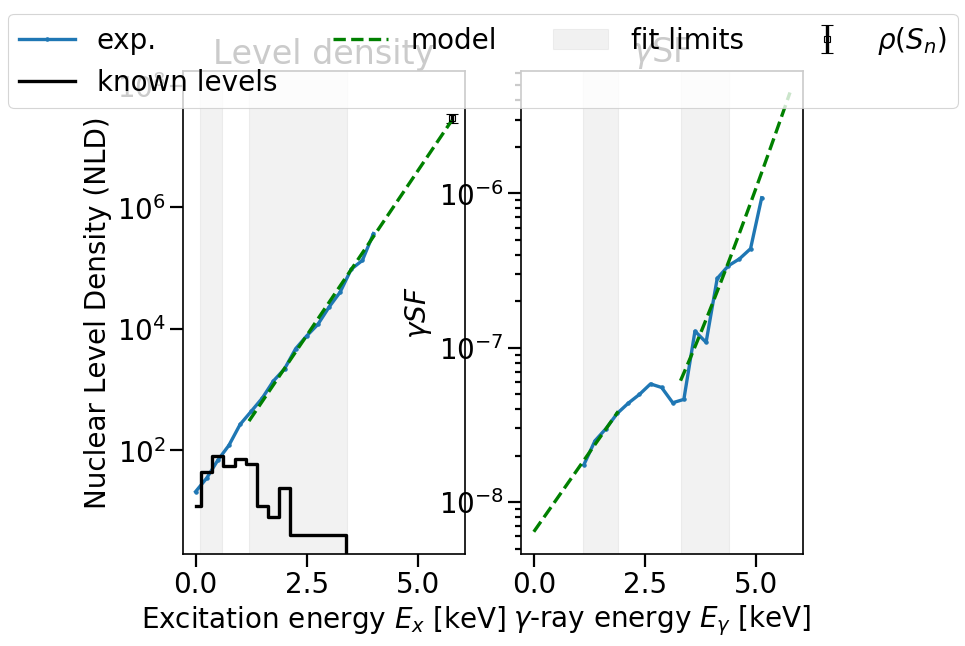

In [26]:
nldnorm, gsfnorm = init_normalizers()
simnorm, fig = norm_sim(nldnorm, gsfnorm)

In [27]:
def norm_sim_ensemble(nldnorm, gsfnorm):
    normlog = om.introspection.get_logger('normalizer_emsemble_simultan', 'INFO')
    ensemblenorm_sim = om.EnsembleNormalizer(extractor=extractor, 
                                             normalizer_simultan=simnorm, 
                                             regenerate=regenerator,
                                              path=norm_path)
    ensemblenorm_sim.normalize()
    ensemblenorm_sim.save_results_txt(data_path)

    fig, ax = plt.subplots(1,2, figsize=(20, 11))
    ensemblenorm_sim.plot(ax=ax, n_plot=5, add_figlegend=False)#, random_state=np.random.default_rng(65546645));
    fig.legend(loc=9, ncol=4, frameon=True)
    ax[1].set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]')
    ax[0].set_xlabel('Excitation energy $E_x$ [keV]')
    ax[0].set_ylabel('Level Density $\\rho(E_x)$ $[MeV^{-1}]$')
    ax[1].set_ylabel('$\gamma-SF$ $f(E_\gamma)\sim [MeV^{-3}]$')
    fig.savefig(plot_path+'ensemble_simnorm')
    return ensemblenorm_sim, fig

2021-02-04 22:46:27,167 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬────────────────────┬─────────────────────┬─────────────────────┐
│ A                 │ α [MeV⁻¹]          │ T [MeV]             │ Eshift [MeV]        │
╞═══════════════════╪════════════════════╪═════════════════════╪═════════════════════╡
│ 6.517139166772528 │ 2.0170017731192633 │ 0.40462509198192825 │ -0.8082807519870563 │
└───────────────────┴────────────────────┴─────────────────────┴─────────────────────┘
2021-02-04 22:46:27,306 - ompy.normalizer_gsf - INFO - Normalizing #0
2021-02-04 22:46:27,316 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌───────────────────┬────────────────────┬─────────────────────┬─────────────────────┬───────────────────┐
│ A                 │ α [MeV⁻¹]          │ T [MeV]             │ Eshift [MeV]        │ B                 │
╞═══════════════════╪════════════════════╪═════════════════════╪═════════════════════╪═══════════════════╡
│ 6.517139166772528 │

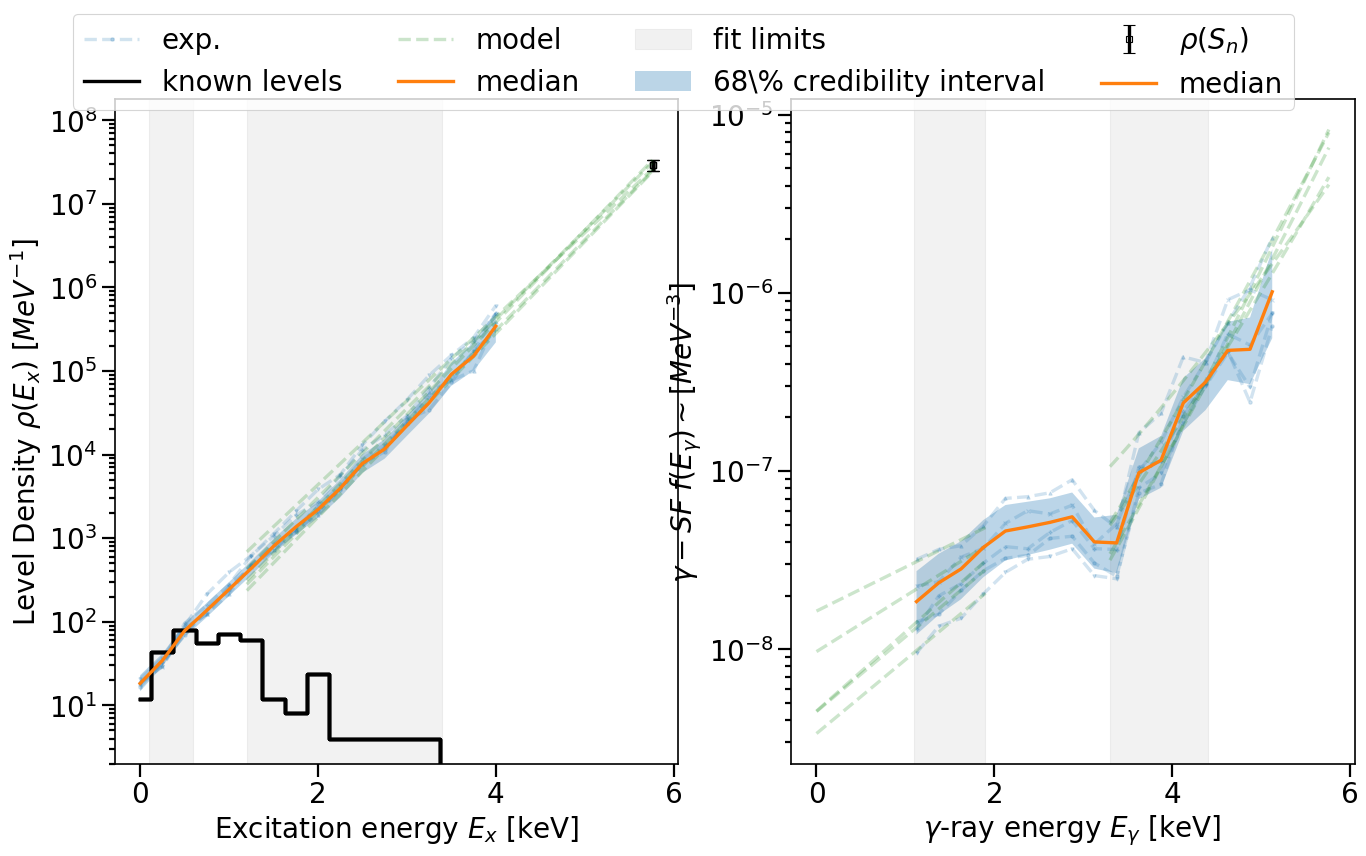

In [28]:
ensemblenorm, fig = norm_sim_ensemble(nldnorm, gsfnorm)

Writing out data ready for analysis

In [29]:
def getMedianQuantile(func):
    """
    Estimating median and the 
    68% confidence interval
    """
    func = pd.DataFrame(func)
    func_median = pd.DataFrame.median(func)
    func_error_low = func.quantile(0.16)
    func_error_high = func.quantile(0.84)
    func_error = func_error_high - func_error_low
    return func_median, func_error

def read_write_ompy(path):
    """
    Read data from saved OmPy results.
    Results to file
    Calculate median and error of results
    Save results to file
    """
    infile = open(path+'README.txt', 'r')
    for line in infile:
        values = line.split()
        if not values:
            continue
        if values[0] == 'rhoSn:':
            rhoSn = float(values[1])
            rhoSn_err = float(values[3])
    infile.close()
    
    parameter_dict = {'keV_per_bin': kev_per_bin_wish, 'Ex_min': Ex_min, 'Ex_max': Ex_max, 'Eg_min': Eg_min, 'Eg_max': Eg_max, 'Gg': Gg, 'Gg_err': Gg_err, 'rhoSn': rhoSn, 'rhoSn_err': rhoSn_err}
    dataFrame1 = pd.DataFrame(parameter_dict, index=[0])
    
    energy_gsf = pd.read_csv(path+'/data/gsf_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    energy_nld = pd.read_csv(path+'/data/nld_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    gsf = []
    nld = []
    
    for i in range(ensemble_members-1):
        gsf.append(pd.read_csv(path+'data/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1])
        nld.append(pd.read_csv(path+'data/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1])
    
    gsf_median, gsf_error = getMedianQuantile(gsf)
    nld_median, nld_error = getMedianQuantile(nld)
    
    ompy_dict = {'E_gamma': energy_gsf, 'gSF-median':gsf_median, 'gSF-error': gsf_error, 'E_x': energy_nld, 'NLD-median': nld_median, 'NLD-error': nld_error}
    
    #write to file
    dataFrame2 = pd.DataFrame(ompy_dict)
    dataFrame = pd.concat([dataFrame1, dataFrame2])
    dataFrame.to_csv(path+'data_for_analysis.csv')

read_write_ompy(path)